# Evolutionary Algorithms (Part 2)

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.utils import io
from statistics import mean

We will start by considering the one max problem again, where a solution is a vector of length _n_, consisting of binary numbers.

In [2]:
n = 20

In [3]:
def get_random_solution():
    return [random.choice([0,1]) for _ in range(n)]

The fitness function as well as variation operators are still the same:

In [4]:
def get_fitness(solution):
    return sum(solution)

In [5]:
def mutate(individual):
    P_mutate = 1/len(individual)
    copy = individual[:]
    for position in range(len(individual)):
        if random.random() < P_mutate:
            copy[position] = 1 - copy[position]
    return copy

In [6]:
def singlepoint_crossover(parent1, parent2):
    pos = random.randint(0, len(parent1))
    offspring1 = parent1[:pos] + parent2[pos:]
    offspring2 = parent2[:pos] + parent1[pos:]
    return offspring1, offspring2

The first selection operator we considered was tournament selection:

In [7]:
tournament_size = 5
def tournament_selection(population, replacement=False):
    if replacement:
        candidates = random.choices(population, k=tournament_size)
    else:
        candidates = random.sample(population, tournament_size)
        
    winner, fitness = max([(x, get_fitness(x)) for x in candidates], key=lambda item:item[1])
    return winner

A general problem in evolutionary search is finding the right balance between exploration and exploitation. Using the wrong operators may lead to premature convergence, or the search may never converge at all at an optimum. As a first step towards understanding what is happening inside the population of a genetic algorithm, we will consider the _average fitness_ of the population as well as the _diversity_ within the population in addition to the best fitness value we already tracked in the past. For this, we first define the difference between two individuals as the hamming distance between the vector representations:

In [8]:
def hamming_distance(individual1, individual2):
    return sum(c1 != c2 for c1, c2 in zip(individual1, individual2))

We can now calculate an overall population diversity as the sum of pairwise hamming distances for all pairs of individuals in the population.

In [9]:
def pairwise_distance(population):
    distances = 0
    for i in range(len(population)-1):
        for j in range(i, len(population)):
           distances += hamming_distance(population[i], population[j]) 
    return distances

We need to set the parameters of our genetic algorithm first:

In [10]:
population_size = 20
P_xover   = 0.7
max_steps = 1000
selection = tournament_selection
crossover = singlepoint_crossover

# These lists track values throughout the evolution
# so we can compare the behaviour of different operators
fitness_values = []
diversity_values = []
mean_fitness_values = []

In the lecture we discussed that there are many different variations of all the search operators involved in a genetic algorithm. We will now look at a couple of relevant search operators.

## Survivor Selection

Most evolutionary algorithms use a fixed population size, so we need a way of going from (parents + offspring) to the next generation. 
- In age-based selection one usually produces as many offspring as there are parents, and then replaces the parents with the offspring. 
- In fitness-based selection, we rank the parents and the offspring, and take the best of all.

We saw both versions last time in the context of evolution strategies, but can also create versions of a genetic algorithm. In a generational genetic algorithm the offspring replaces the parents, while in a steady state genetic algorithm we apply fitness-based survivor selection.

Elitism is a special case, where the best individuals of the population always survive, while other means are used for the rest of the population. We implement a simple version of elitism by simply ranking the population by diversity and taking the top `elite_size` elements:

In [11]:
elite_size = int(population_size * 0.05)

def elitism(population):
    population.sort(key=lambda k: get_fitness(k), reverse=True)
    return population[:elite_size]

Let's revisit the standard genetic algorithm with a generational selection model, integrated with elitism:

In [12]:
def ga():
    population = [get_random_solution() for _ in range(population_size)]

    # This could probably be written in a single line, but let's keep it explicit
    best_fitness = -1
    step = 0
    for p in population:
        fitness = get_fitness(p)
        if fitness > best_fitness:
            best_fitness = fitness
        step += 1
        fitness_values.append(best_fitness)

    diversity_values.append(pairwise_distance(population))
    mean_fitness_values.append(mean([get_fitness(x) for x in population]))

    iteration = 0
    print("Iteration {}, best fitness: {}".format(iteration, best_fitness))
    while step < max_steps:
        iteration += 1
        new_population = elitism(population)
        while len(new_population) < len(population):
            parent1 = selection(population)
            parent2 = selection(population)

            if random.random() < P_xover:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1[:], parent2[:]

            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)
            
            fitness1, fitness2 = get_fitness(offspring1), get_fitness(offspring2)
            step += 2
            if fitness1 > best_fitness:
                best_fitness = fitness1
                print("Iteration {}, best fitness: {}".format(iteration, best_fitness))
            fitness_values.append(best_fitness)
            if fitness2 > best_fitness:
                best_fitness = fitness2
                print("Iteration {}, best fitness: {}".format(iteration, best_fitness))
            fitness_values.append(best_fitness)
            
            new_population += [offspring1, offspring2]

        population = new_population
        diversity_values.append(pairwise_distance(population))
        mean_fitness_values.append(mean([get_fitness(x) for x in population]))

    return max(population, key=lambda k: get_fitness(k))

The alternative was the steady state genetic algorithm, where we select two parents, derive their offspring, and then do fitness-based survivor selection:

In [13]:
def steadystatega():
    population = [get_random_solution() for _ in range(population_size)]
    best_fitness = -1
    step = 0
    for p in population:
        fitness = get_fitness(p)
        step += 1
        if fitness > best_fitness:
            best_fitness = fitness
            best_solution = p
        fitness_values.append(best_fitness)
    print(f"Iteration 0, best fitness: {best_fitness}")
    diversity_values.append(pairwise_distance(population))
    mean_fitness_values.append(mean([get_fitness(x) for x in population]))
    
    iteration = 0
    while step < max_steps:
        iteration += 1
                
        parent1 = selection(population)
        parent2 = selection(population)
        
        p1 = population.index(parent1)
        p2 = population.index(parent2)

        if random.random() < P_xover:
            offspring1, offspring2 = crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1[:], parent2[:]

        offspring1 = mutate(offspring1)
        offspring2 = mutate(offspring2)
        
        best1, best2 = sorted([parent1, parent2, offspring1, offspring2], key=lambda item:get_fitness(item), reverse=True)[:2]
        population[p1] = best1
        population[p2] = best2
        step += 2

        if get_fitness(best1) > best_fitness or get_fitness(best2) > best_fitness:
            best_fitness = max(get_fitness(best1), get_fitness(best1))
            print(f"Iteration {iteration}, best fitness: {best_fitness}")

        fitness_values.append(best_fitness)
        fitness_values.append(best_fitness)
        
        # To make plots comparable with the generational GA
        if step % population_size == 0:
            diversity_values.append(pairwise_distance(population))
            mean_fitness_values.append(mean([get_fitness(x) for x in population]))
            
    return best_solution

Note that there are further possibilities for variation here: Instead of replacing the selected parents in the population, we could select other individuals (e.g., the worst individuals).

To consider the effects on diversity, let's compare diversity and fitness throughout one run each. We'll increase `n` to make the problem slightly more challenging.

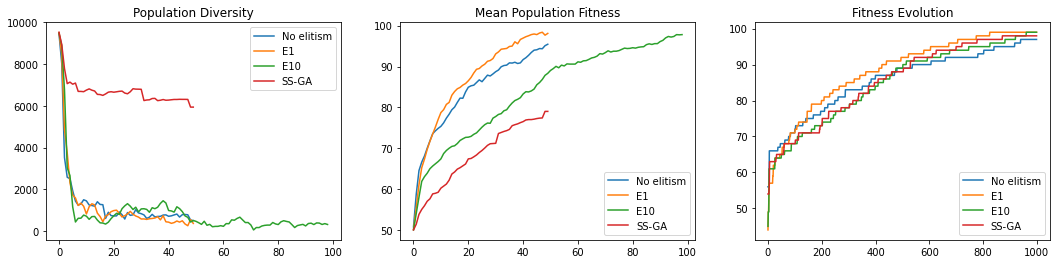

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
n = 100
max_steps = 1000
population_size = 20

with io.capture_output() as captured: 
    elite_size = 0
    fitness_values = []
    diversity_values = []
    mean_fitness_values = []
    ga()
    axes[0].plot(diversity_values, label=f"No elitism")
    axes[1].plot(mean_fitness_values, label=f"No elitism")
    axes[2].plot(fitness_values, label=f"No elitism")

    elite_size = 1
    fitness_values = []
    diversity_values = []
    mean_fitness_values = []
    ga()
    axes[0].plot(diversity_values, label=f"E1")
    axes[1].plot(mean_fitness_values, label=f"E1")
    axes[2].plot(fitness_values, label=f"E1")
    
    elite_size = 10
    fitness_values = []
    diversity_values = []
    mean_fitness_values = []
    ga()
    axes[0].plot(diversity_values, label=f"E10")
    axes[1].plot(mean_fitness_values, label=f"E10")
    axes[2].plot(fitness_values, label=f"E10")
    
    fitness_values = []
    diversity_values = []
    mean_fitness_values = []
    steadystatega()
    axes[0].plot(diversity_values, label=f"SS-GA")
    axes[1].plot(mean_fitness_values, label=f"SS-GA")
    axes[2].plot(fitness_values, label=f"SS-GA")

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Fitness Evolution')
axes[2].legend()
plt.show()

As usual results may vary between runs, since these are randomised algorithms. However, a general trend we should see in the above plots is that the population diversity of the steady state GA reduces much slower than in a generational GA, and also the average fitness value in the population remains lower. The large elitism size of `10` means that the algorithm can run more generations with the same number of fitness evaluations, which is why it continues longer than the others in the first two plots. A small elitism size tends to generally lead to a better average fitness in this configuration. The best performing version will differ between runs.

## Parent Selection

A major difference between the evolution strategies we considered initially and the canonical genetic algorithm we looked at afterwards is the parent selection strategy. In classical evolution strategies all μ (mu) parents are involved in recombination, and the survivor selection is what drives the selective pressure. In genetic algorithms, instead, the parent selection applies selective pressure. 

We started off with tournament selection because it is the quickest to implement. A traditionally more common variant is fitness proportionate selection, where the probability of an individual to be selected is proportional to its fitness value. The selection thus first calculates the total fitness sum, and then probabilistically chooses an individual by sampling a number in the range between 0 and the total fitness sum. An important requirement is that the population is sorted by fitness values, starting with the best individual (largest fitness).  This selection operator is also known as _roulette wheel selection_.

In our simple implementation, we create a list of tuples `fitness_list` that stores individuals with their fitness. Obviously, there's some redundant fitness calculations here; in practice one would cache fitness values.

In [15]:
def roulette_selection(population):
    fitness_list = [(x, get_fitness(x)) for x in population]
    fitness_sum = sum([f for (c, f) in fitness_list])
    fitness_list.sort(key=lambda c: c[1], reverse=True)
    pick = random.uniform(0, fitness_sum)
    current = 0
    for (chromosome, fitness) in fitness_list:
        current += fitness
        if current > pick:
            return chromosome

To evaluate this, let's create a simple example population for `n=5` with individuals with fitness 5, 4, 3, 2, 1, and 0:

In [16]:
example_population = [ [1,1,1,1,1], [0,1,1,1,1], [0,0,1,1,1], [0,0,0,1,1], [0,0,0,0,1], [0,0,0,0,0]  ]

Applying this selection operator will more likely select the best individual(s) (but may select worse individuals as well). We can do a simple experiment by sampling repeatedly from our `example_population` and looking at the resulting histogram:

([<matplotlib.axis.XTick at 0x119d16f70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

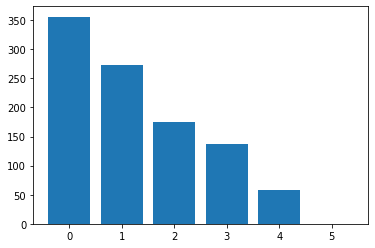

In [17]:
counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = roulette_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()))

A problem with fitness proportionate selection is that individuals that have a much better fitness value will dominate the selection. For example, let's skew our example population:

In [18]:
example_population = [ [1,1,1,1,1], [0,1,0,0,0], [1,0,0,0,0], [0,0,1,0,0], [0,0,0,1,0],[0,0,0,0,0] ]

In this population, the first individual has fitness value 5, while the other individuals have fitness 1 and 0. The sum of fitness values is 9, and so the first individual has a probability of 56% of being selected:

([<matplotlib.axis.XTick at 0x119f96700>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

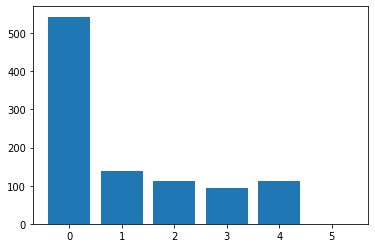

In [19]:
counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = roulette_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()))

Tournament selection, which we implemented earlier, suffers less from this problem. In tournament selection, we can adjust the _selective pressure_ by adjusting the tournament size. With our example population of size 3, a tournament size of 2 without replacement would imply a 67% chance of the best of the three individuals being selected:

([<matplotlib.axis.XTick at 0x119ff4520>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

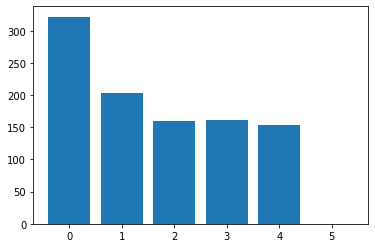

In [20]:
tournament_size = 2

counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = tournament_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()))

Let's also compare this to the population with a more equal spread:

([<matplotlib.axis.XTick at 0x11a05b2e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

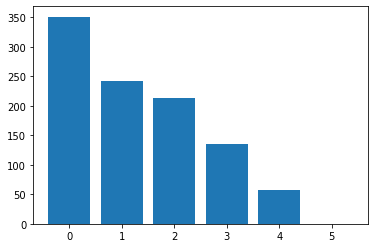

In [21]:
example_population = [ [1,1,1,1,1], [0,1,1,1,1], [0,0,1,1,1], [0,0,0,1,1], [0,0,0,0,1], [0,0,0,0,0]  ]

counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = tournament_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()))

To see the effects of the tournament size on the selection, let's repeat this with a larger tournament size, which means higher selective pressure:

([<matplotlib.axis.XTick at 0x11a0ce3d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

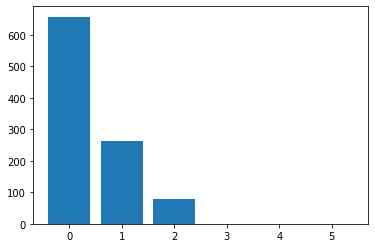

In [22]:
tournament_size = 4

counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = tournament_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()))

Even with small tournament size the worst individual was not chosen in any of these cases. The reason is that we are using tournament selection _without_ replacement. If we pick any two individuals out of `example_population`, the individual with fitness 0 will _always_ be worse. If we use replacement, then there is a chance that the worst individual gets selected:

([<matplotlib.axis.XTick at 0x11a129e80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

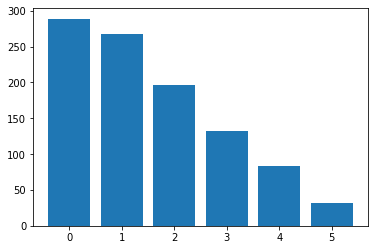

In [23]:
tournament_size = 2

counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = tournament_selection(example_population, replacement=True)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()))

We can also observe the effects of the selective pressure throughout evolution.

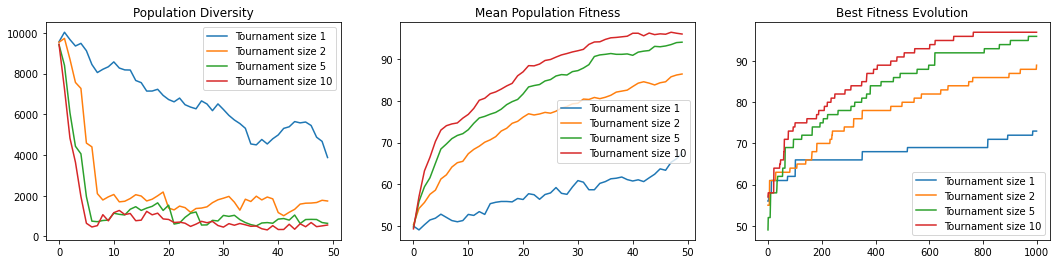

In [24]:
n = 100
from IPython.utils import io

elite_size = 1
selection = tournament_selection
tournament_sizes = [1, 2, 5, 10]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
for tournament_size in tournament_sizes:
    fitness_values = []
    diversity_values = []
    mean_fitness_values = []
    with io.capture_output() as captured: 
        ga()
    axes[0].plot(diversity_values, label=f"Tournament size {tournament_size}")
    axes[1].plot(mean_fitness_values, label=f"Tournament size {tournament_size}")
    axes[2].plot(fitness_values, label=f"Tournament size {tournament_size}")

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Best Fitness Evolution')
axes[2].legend()
plt.show()

Too little selective pressure (e.g., tournament size of 1) tends to be bad. Very large tournaments might be too eager (which is not so much of a problem in one max though).

Should we use fitness proportionate selection or tournament selection?

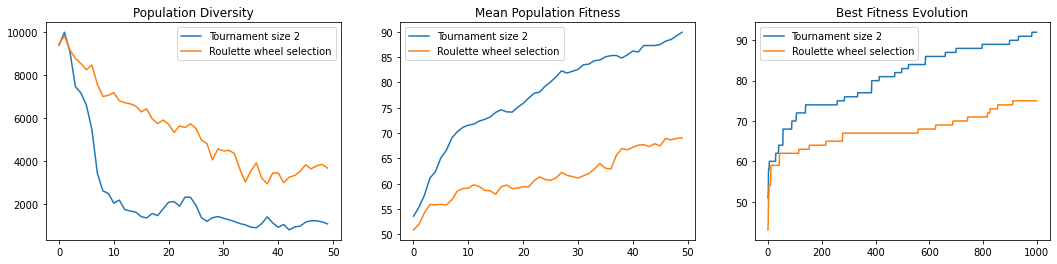

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
n = 100
with io.capture_output() as captured: 
    fitness_values = []
    diversity_values = []
    mean_fitness_values = []
    selection = tournament_selection
    tournament_size = 2
    ga()
    axes[0].plot(diversity_values, label=f"Tournament size {tournament_size}")
    axes[1].plot(mean_fitness_values, label=f"Tournament size {tournament_size}")
    axes[2].plot(fitness_values, label=f"Tournament size {tournament_size}")

    selection = roulette_selection
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Roulette wheel selection")
    axes[1].plot(mean_fitness_values, label=f"Roulette wheel selection")
    axes[2].plot(fitness_values, label=f"Roulette wheel selection")

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Best Fitness Evolution')
axes[2].legend()
plt.show()

An alternative selection operator is _rank selection_, which is similar to fitness proportionate selection, except that the probability is calculated based on the _rank_ in the population sorted by fitness, rather than the actual fitness value.

In [26]:
rank_bias = 2
def rank_selection(population):
    population.sort(key=lambda c: get_fitness(c), reverse=True)
    
    individuals = []
    N = len(population)
    for i in range(N):
        f2 = rank_bias - (2 * i * (rank_bias - 1))/(N - 1)
        individuals.append((population[i], f2))

    # Now implement fitness proportionate selection using the f2 values
    fitness_sum = sum([f for (c, f) in individuals])
    pick = random.uniform(0, fitness_sum)
    current = 0
    for (chromosome, fitness) in individuals:
        current += fitness
        if current > pick:
            return chromosome

The bias allows us to adjust the selective pressure. With a bias of `2`, the worst individual has a 0% chance of being selected:

([<matplotlib.axis.XTick at 0x11a2bd640>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

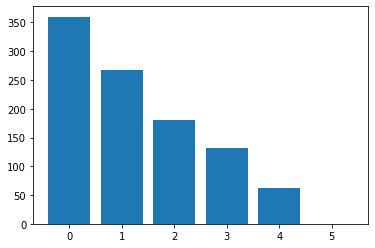

In [27]:
rank_bias = 2

example_population = [ [1,1,1,1,1], [0,1,0,0,0], [1,0,0,0,0], [0,0,1,0,0], [0,0,0,1,0],[0,0,0,0,0] ]
counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = rank_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()))

With a bias of `1`, all individuals have the same probability of being selected:

([<matplotlib.axis.XTick at 0x11a2fa7c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

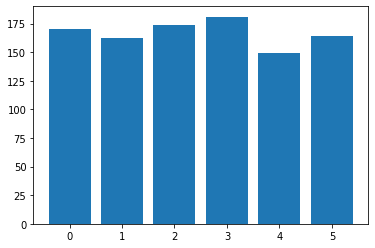

In [28]:
rank_bias = 1

example_population = [ [1,1,1,1,1], [0,1,0,0,0], [1,0,0,0,0], [0,0,1,0,0], [0,0,0,1,0],[0,0,0,0,0] ]
counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = rank_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()))

We will select a reasonable default for the selective pressure:

([<matplotlib.axis.XTick at 0x11a3720a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

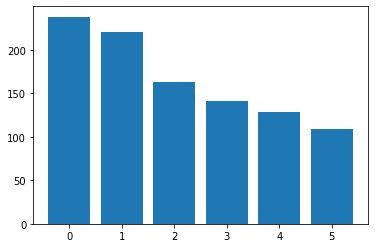

In [29]:
rank_bias = 1.4

example_population = [ [1,1,1,1,1], [0,1,0,0,0], [1,0,0,0,0], [0,0,1,0,0], [0,0,0,1,0],[0,0,0,0,0] ]
counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = rank_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()))

We can again observe the effects of the rank bias on the evolution:

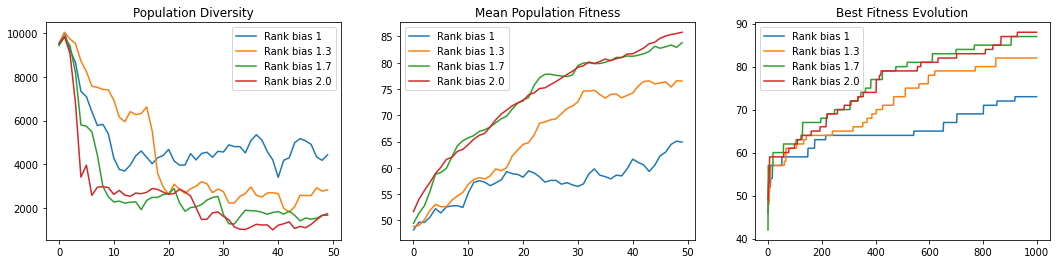

In [30]:
from IPython.utils import io
selection = rank_selection
rank_biases = [1, 1.3, 1.7, 2.0]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
for rank_bias in rank_biases:
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    with io.capture_output() as captured: 
        ga()
    axes[0].plot(diversity_values, label=f"Rank bias {rank_bias}")
    axes[1].plot(mean_fitness_values, label=f"Rank bias {rank_bias}")
    axes[2].plot(fitness_values, label=f"Rank bias {rank_bias}")

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Best Fitness Evolution')
axes[2].legend()
plt.show()

Some variants of genetic algorithms use selection where each individual has the same chance of being selected. Although this removes selection pressure, this is usually compensated with a strong fitness-based survivor selection mechanism.

In [31]:
def uniform_selection(population):
    return random.choice(population)

We would not usually use uniform selection without some other survival selection, but to see what the effects on the search are, let's put all the options together in one experiment.

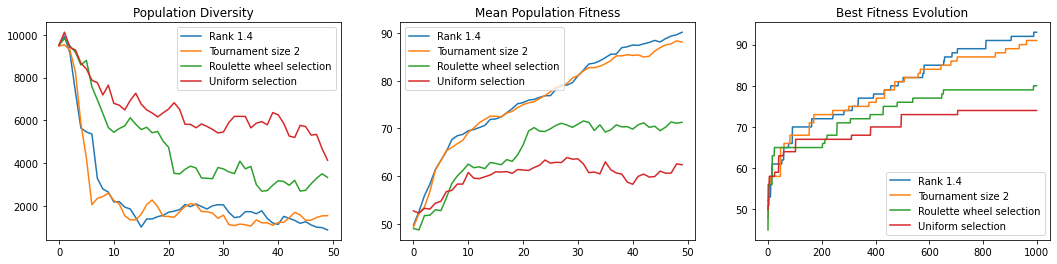

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
n = 100
with io.capture_output() as captured: 
    rank_bias = 1.4
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    selection = tournament_selection
    tournament_size = 2
    ga()
    axes[0].plot(diversity_values, label=f"Rank {rank_bias}")
    axes[1].plot(mean_fitness_values, label=f"Rank {rank_bias}")
    axes[2].plot(fitness_values, label=f"Rank {rank_bias}")

    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    selection = tournament_selection
    tournament_size = 2
    ga()
    axes[0].plot(diversity_values, label=f"Tournament size {tournament_size}")
    axes[1].plot(mean_fitness_values, label=f"Tournament size {tournament_size}")
    axes[2].plot(fitness_values, label=f"Tournament size {tournament_size}")

    selection = roulette_selection
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Roulette wheel selection")
    axes[1].plot(mean_fitness_values, label=f"Roulette wheel selection")
    axes[2].plot(fitness_values, label=f"Roulette wheel selection")

    selection = uniform_selection
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Uniform selection")
    axes[1].plot(mean_fitness_values, label=f"Uniform selection")
    axes[2].plot(fitness_values, label=f"Uniform selection")

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Best Fitness Evolution')
axes[2].legend()
plt.show()

## Alternative Crossover Operators

Our crossover operator so far only considers a single point for crossing two individuals. While this is the most common variant in practice, there is one potential downside: Only locally neighbouring genetic material is preserved; if a parent has relevant genes at the beginning and the end of the chromosome, these will not be inherited to the offspring directly. One way to circumvent this is by defining more than one crossover point. For example, we can define a two-point crossover operator:

In [33]:
def twopoint_crossover(parent1, parent2):
    pos1 = random.randint(1, len(parent1))
    pos2 = random.randint(pos1, len(parent1))
    offspring1 = parent1[:pos1] + parent2[pos1:pos2] + parent1[pos2:]
    offspring2 = parent2[:pos1] + parent1[pos1:pos2] + parent2[pos2:]
    return offspring1, offspring2


In [34]:
parent1 = [0,0,0,0,0,0,0,0,0,0]
parent2 = [1,1,1,1,1,1,1,1,1,1]

In the single point crossover, the offspring of `parent1` and `parent2` will _always_ be either a sequence of `0` followed by a sequence of `1`, or vice versa:

In [35]:
singlepoint_crossover(parent1, parent2)

([0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In the two point crossover, there will be some variation:

In [36]:
twopoint_crossover(parent1, parent2)

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

While it is unlikely to make a big difference on our one max example, we can integrate the two point crossover operator into our algorithm and check that it still works:

Iteration 0, best fitness: 57
Iteration 1, best fitness: 59
Iteration 2, best fitness: 61
Iteration 3, best fitness: 65
Iteration 4, best fitness: 66
Iteration 5, best fitness: 67
Iteration 6, best fitness: 68
Iteration 8, best fitness: 71
Iteration 11, best fitness: 73
Iteration 13, best fitness: 74
Iteration 16, best fitness: 75
Iteration 19, best fitness: 76
Iteration 20, best fitness: 77
Iteration 20, best fitness: 78
Iteration 24, best fitness: 79
Iteration 24, best fitness: 80
Iteration 25, best fitness: 81
Iteration 27, best fitness: 82
Iteration 29, best fitness: 83
Iteration 31, best fitness: 84
Iteration 35, best fitness: 85
Iteration 38, best fitness: 86
Iteration 42, best fitness: 87
Iteration 48, best fitness: 88


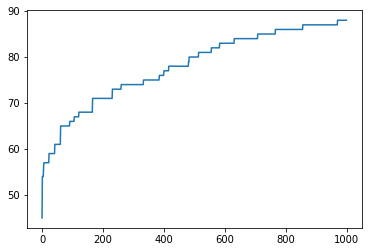

In [37]:
crossover = twopoint_crossover
selection = tournament_selection
fitness_values = []
ga()
plt.plot(fitness_values)

It is not common to increase the number of crossover points beyond two, but instead of more variation is required, it is simply possible to _uniformly_ select genes from either of the parents, resulting in _uniform crossover_:

In [38]:
def uniform_crossover(parent1, parent2):
    offspring1 = []
    offspring2 = []
    for pos in range(len(parent1)):
        if random.choice([True, False]):
            offspring1.append(parent1[pos])
            offspring2.append(parent2[pos])
        else:
            offspring1.append(parent2[pos])
            offspring2.append(parent1[pos])
    return offspring1, offspring2

Applying this to `parent1` and `parent2` from above, we will see offspring consisting of more variation in `1`s and `0`s, but these will always be chosen from parents and not random:

In [39]:
uniform_crossover(parent1, parent2)

([0, 1, 0, 0, 0, 1, 0, 1, 1, 1], [1, 0, 1, 1, 1, 0, 1, 0, 0, 0])

Although it's not going to make a huge difference on our one max example, we can check if the genetic algorithm still works with this crossover operator:

Iteration 0, best fitness: 56
Iteration 1, best fitness: 59
Iteration 5, best fitness: 62
Iteration 5, best fitness: 63
Iteration 7, best fitness: 64
Iteration 8, best fitness: 66
Iteration 8, best fitness: 68
Iteration 9, best fitness: 69
Iteration 12, best fitness: 71
Iteration 14, best fitness: 73
Iteration 17, best fitness: 74
Iteration 18, best fitness: 75
Iteration 19, best fitness: 76
Iteration 20, best fitness: 78
Iteration 21, best fitness: 79
Iteration 22, best fitness: 82
Iteration 23, best fitness: 83
Iteration 25, best fitness: 86
Iteration 26, best fitness: 87
Iteration 27, best fitness: 88
Iteration 31, best fitness: 89
Iteration 32, best fitness: 90
Iteration 33, best fitness: 91
Iteration 35, best fitness: 92
Iteration 40, best fitness: 93
Iteration 44, best fitness: 94


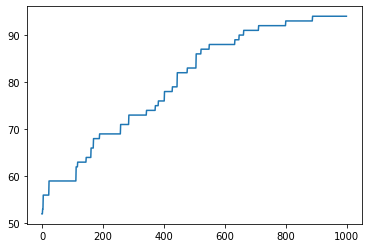

In [40]:
crossover = uniform_crossover
fitness_values = []
ga()
plt.plot(fitness_values)

The importance and influence of the crossover operator on the search is part of active research, and also depends on the problem we are trying to solve. To see whether there are any benefits to using crossover on our one max example, we can conduct a _headless chicken_ test: During crossover, we use a randomly generated individual as one of the parents. If the search still performs as well, then the crossover operator actually just serves as a kind of macro-mutation. If the search no longer performs as well, then it is the actual combination of parent genetic material that leads to an improvement.

In [41]:
def chicken_crossover(parent1, parent2):
    offspring1 = []
    offspring2 = []
    parent2 = get_random_solution()
    for pos in range(len(parent1)):
        if random.choice([True, False]):
            offspring1.append(parent1[pos])
            offspring2.append(parent2[pos])
        else:
            offspring1.append(parent2[pos])
            offspring2.append(parent1[pos])
    return offspring1, offspring2

We will run the usual combination of experiments and analyses:

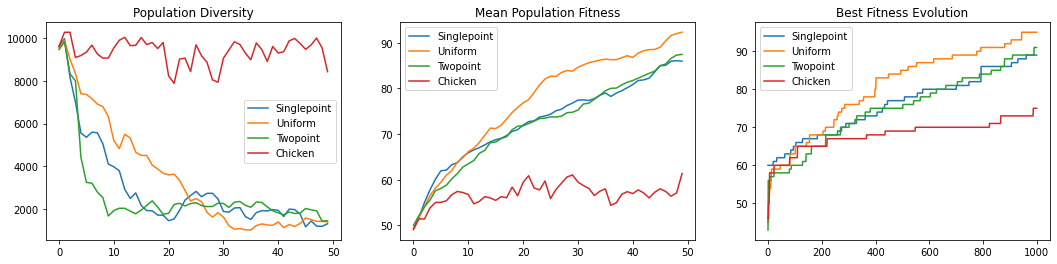

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
n = 100
with io.capture_output() as captured: 
    crossover = singlepoint_crossover
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Singlepoint")
    axes[1].plot(mean_fitness_values, label=f"Singlepoint")
    axes[2].plot(fitness_values, label=f"Singlepoint")

    crossover = uniform_crossover
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Uniform")
    axes[1].plot(mean_fitness_values, label=f"Uniform")
    axes[2].plot(fitness_values, label=f"Uniform")
    
    crossover = twopoint_crossover
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Twopoint")
    axes[1].plot(mean_fitness_values, label=f"Twopoint")
    axes[2].plot(fitness_values, label=f"Twopoint")
    
    crossover = chicken_crossover
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Chicken")
    axes[1].plot(mean_fitness_values, label=f"Chicken")
    axes[2].plot(fitness_values, label=f"Chicken")

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Best Fitness Evolution')
axes[2].legend()
plt.show()

This experiment just conducts a single run, and as usual we need to conduct an experiment with repetitions in order to draw conclusions. However, what most likely shows is that the headless chicken test leads to substantially worse results, while the uniform crossover tends to produce the best results. Consequently, it seems that crossover actually is useful for our problem.

## Example Application: Software Module Clustering

The software module clustering problem is a classical example of where local search was applied to solve problems in software engineering. It dates back to this paper and the corresponding _Bunch_ tool:

Mitchell, B. S., & Mancoridis, S. (2006). On the automatic modularization of software systems using the bunch tool. IEEE Transactions on Software Engineering, 32(3), 193-208.

The aim is to find a good partitioning of the software structure. A partition is a decomposition of a set of elements into mutually disjoint clusters. A _good_ partition is a partition where highly interdependent nodes are grouped in the same clusters, while independent nodes are assigned to separate clusters.

We will use an example from the Bunch tool to apply search ourselves. The data for a software module clustering problem consists of individuals _modules_, and _connections_ between these modules.

In [43]:
module_ids = {}
name_to_id = {}
connections = []

The dictionaries `module_ids` and `name_to_id` map from module names to numerical IDs and back. The list `connections` consists of tuples of endpoints of connections. We will parse data using the Bunch example format:

In [44]:
def parse_mdg(filename):
    with open(filename) as f:
        content = [x.strip() for x in f.readlines()]

    for line in content:
        if line.strip() == "":
            continue
        module1, module2 = line.split()
        num_module1 = len(module_ids)
        if module1 in name_to_id:
            num_module1 = name_to_id[module1]
        else:
            name_to_id[module1] = num_module1
        module_ids[num_module1] = module1
        num_module2 = len(module_ids)
        if module2 in name_to_id:
            num_module2 = name_to_id[module2]
        else:
            name_to_id[module2] = num_module2
        module_ids[num_module2] = module2

        connections.append((num_module1, num_module2))

To illustrate the problem, we will consider the _compile_ example:

In [45]:
parse_mdg("data/mdg/compiler.mdg")

This problem consists of 13 individual modules:

In [46]:
name_to_id.keys()

dict_keys(['main', 'declarations', 'parser', 'codeGenerator', 'scanner', 'scopeController', 'typeChecker', 'dictionary', 'dictIdxStack', 'addrStack', 'dictStack', 'typeStack', 'argCntStack'])

Some of these are connected (e.g. via method calls):

In [47]:
[(module_ids[x], module_ids[y]) for (x,y) in connections]

[('main', 'declarations'),
 ('main', 'parser'),
 ('main', 'codeGenerator'),
 ('parser', 'declarations'),
 ('parser', 'scanner'),
 ('parser', 'scopeController'),
 ('parser', 'typeChecker'),
 ('parser', 'codeGenerator'),
 ('codeGenerator', 'declarations'),
 ('codeGenerator', 'dictionary'),
 ('codeGenerator', 'dictIdxStack'),
 ('codeGenerator', 'scopeController'),
 ('codeGenerator', 'addrStack'),
 ('scanner', 'declarations'),
 ('scopeController', 'declarations'),
 ('scopeController', 'dictionary'),
 ('scopeController', 'dictIdxStack'),
 ('scopeController', 'dictStack'),
 ('typeChecker', 'declarations'),
 ('typeChecker', 'dictStack'),
 ('typeChecker', 'dictionary'),
 ('typeChecker', 'dictIdxStack'),
 ('typeChecker', 'typeStack'),
 ('typeChecker', 'argCntStack'),
 ('dictionary', 'declarations'),
 ('dictionary', 'dictStack'),
 ('dictIdxStack', 'declarations'),
 ('dictIdxStack', 'dictStack'),
 ('addrStack', 'declarations'),
 ('dictStack', 'declarations'),
 ('typeStack', 'declarations'),
 ('ar

We can visualise the modules and connections as a graph -- the so called _module dependency graph_. Note that you will need `graphviz` in order to generate graphs in this Jupyter notebook:

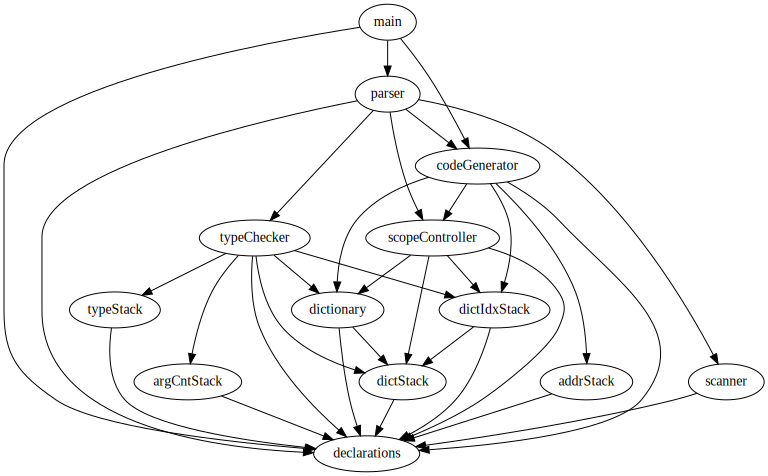

In [48]:
from graphviz import Digraph
dot = Digraph()

for name in module_ids.values():
    dot.node(name)
for (module1, module2) in connections:
    dot.edge(module_ids[module1], module_ids[module2])
dot

A partition assigns each module to a cluster. As representation, we therefore use a list of length _number of modules_ (`n`), where each entry of the list is a number from 0 to `n`:

In [49]:
def get_random_solution():
    num_clusters = len(module_ids)
    return [random.randint(0, num_clusters-1) for _ in range(num_clusters)]

We can define a helper function to visualise the clustering, such that the modules in a cluster are shown in boxes:

In [50]:
def plot_clusters(individual):
    num_cluster = 1
    dot = Digraph()
    
    for cluster in set(individual):
        modules_in_cluster = [position for position in range(len(individual)) if individual[position] == cluster]
        s = Digraph(name='cluster{}'.format(num_cluster))
        for module in modules_in_cluster:
            name = module_ids[module]
            s.node(name)
        num_cluster += 1
        dot.subgraph(s)
    for (module1, module2) in connections:
        dot.edge(module_ids[module1], module_ids[module2])
    return dot

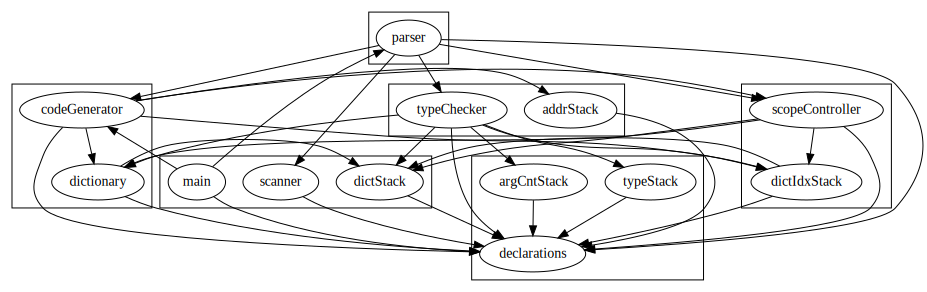

In [51]:
plot_clusters(get_random_solution())

The neighbourhood consists of placing each module in a different cluster. We do not need to explore multiple empty clusters; if there are multiple empty cluster IDs available, then placing a module in just one of them is sufficient.

In [52]:
def get_neighbours(individual):
    clusters = list(set(individual))
    
    # We only need one new cluster, pick the lowest available ID
    new_cluster = min(set(range(0,max(clusters)+2)) - set(clusters))

    clusters.append(new_cluster)
    neighbours = []

    for position in range(len(individual)):
        for cluster in clusters:
            if individual[position] != cluster:
                copy = individual[:]
                copy[position] = cluster
                neighbours.append(copy)

    return neighbours

In [53]:
x = get_random_solution()
x

[2, 7, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9]

In [54]:
get_neighbours(x)

[[7, 7, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [8, 7, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [9, 7, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [10, 7, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [11, 7, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [12, 7, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [0, 7, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 2, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 8, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 9, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 10, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 11, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 12, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 0, 8, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 7, 2, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 7, 7, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 7, 9, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 7, 10, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 7, 11, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 7, 12, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2, 7, 0, 9, 9, 12, 11, 12, 10, 11, 8, 9, 9],
 [2,

The quality of a partitioning depends on how many interdependent nodes are in the same clusters, and how many independent nodes are in separate clusters. This notion is captured in the _Modularisation Quality (MQ)_ metric. 

The MQ is calculated as the sum of modularisation factors of all clusters in a partition. 

$MQ = \Sigma MF_k$

The modularisation factor depends on two factors:
- Intra-edges i: Edges that start and end within the same cluster
- Inter-edges j: Edges which start and end in different clusters

$MF_k = \frac{i}{i + \frac{1}{2}j}$ if $i > 0$ else $0$.

In [55]:
def get_fitness(individual):
    mq = 0.0

    for cluster in set(individual):
        modules_in_cluster = [position for position in range(len(individual)) if individual[position] == cluster]
        i = 0.0
        for pos1 in range(len(modules_in_cluster) - 1):
            for pos2 in range(pos1 + 1, len(modules_in_cluster)):
                if (pos1, pos2) in connections or (pos2, pos1) in connections:
                    i += 1.0
        modules_not_in_cluster = [position for position in range(len(individual)) if individual[position] != cluster]
        j = 0.0
        for pos1 in range(len(modules_not_in_cluster) - 1):
            for pos2 in range(pos1 + 1, len(modules_not_in_cluster)):
                if (pos1, pos2) in connections or (pos2, pos1) in connections:
                    j += 1.0
        mf = 0.0
        if i > 0.0:
            mf = i/(i + 0.5*j)
        mq = mq + mf

    return mq

The larger MQ, the better the modularisation; that is, we can use MQ as a maximisation fitness function.

As a baseline, we'll include a simple hillclimber again.

In [56]:
def hillclimbing():

    current = get_random_solution()
    fitness = get_fitness(current)
    best = current[:]
    best_fitness = fitness
    print(f"Starting at fitness {best_fitness}: {current}")

    step = 0
    while step < max_steps:

        replaced = False
        for neighbour in get_neighbours(current):
            neighbour_fitness = get_fitness(neighbour)
            step += 1
            if neighbour_fitness > fitness:
                current = neighbour
                fitness = neighbour_fitness
                replaced = True
                if fitness > best_fitness:
                    print(f"Iteration {step}, fitness {best_fitness}: {best}")
                    best = current[:]
                    best_fitness = fitness

                fitness_values.append(best_fitness)
                break
            else:
                fitness_values.append(best_fitness)

        # Random restart if no neighbour is better
        if not replaced:
            current = get_random_solution()
            fitness = get_fitness(current)
            step += 1
            if fitness > best_fitness:
                print(f"Iteration {step}, fitness {best_fitness}: {best}")
                best = current[:]
                best_fitness = fitness
                fitness_values.append(best_fitness)


    print(f"Solution fitness {best_fitness}: {best}")
    return best

Here's what the hillclimber suggests for our `compiler` example:

Starting at fitness 0.2: [0, 9, 12, 10, 4, 4, 11, 8, 3, 10, 5, 8, 2]
Iteration 1, fitness 0.2: [0, 9, 12, 10, 4, 4, 11, 8, 3, 10, 5, 8, 2]
Iteration 3, fitness 0.26666666666666666: [2, 9, 12, 10, 4, 4, 11, 8, 3, 10, 5, 8, 2]
Iteration 13, fitness 0.34022988505747126: [4, 9, 12, 10, 4, 4, 11, 8, 3, 10, 5, 8, 2]
Iteration 18, fitness 0.4068965517241379: [4, 2, 12, 10, 4, 4, 11, 8, 3, 10, 5, 8, 2]
Iteration 28, fitness 0.40689655172413797: [10, 2, 12, 10, 4, 4, 11, 8, 3, 10, 5, 8, 2]
Iteration 31, fitness 0.48045977011494256: [10, 4, 12, 10, 4, 4, 11, 8, 3, 10, 5, 8, 2]
Iteration 48, fitness 0.49696969696969695: [4, 4, 12, 10, 4, 4, 11, 8, 3, 10, 5, 8, 2]
Iteration 64, fitness 0.5636363636363636: [4, 4, 2, 10, 4, 4, 11, 8, 3, 10, 5, 8, 2]
Iteration 68, fitness 0.6181818181818182: [4, 4, 4, 10, 4, 4, 11, 8, 3, 10, 5, 8, 2]
Iteration 92, fitness 0.6371995820271682: [8, 4, 4, 10, 4, 4, 11, 8, 3, 10, 5, 8, 2]
Iteration 95, fitness 0.6917450365726228: [8, 4, 4, 4, 4, 4, 11, 8, 3, 10, 5, 8, 2]


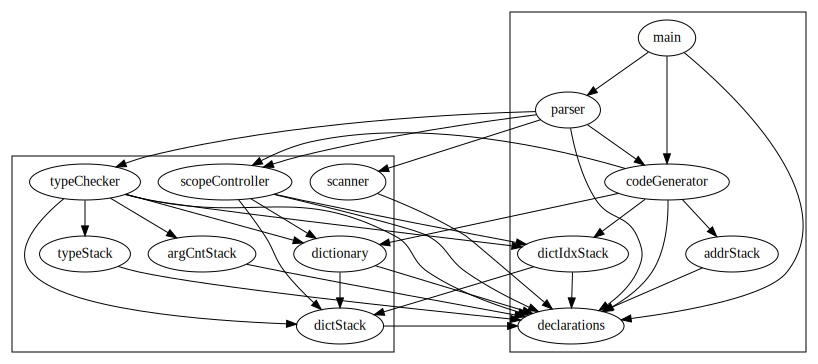

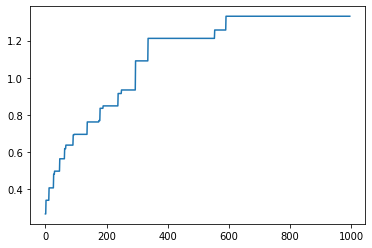

In [57]:
fitness_values = []
solution = hillclimbing()
plt.plot(fitness_values)
plot_clusters(solution)

To apply evolutionary search, we need to define variation operators for the representation. Since the representation is a basic list, we can apply our usual crossover operators, but we need to add a custom mutation operator. To mutate, we will place each of the modules into a different cluster with a certain probability depending on the number of modules:

In [58]:
def mutate(individual):
    P_mutate = 1/len(individual)
    clusters = list(set(individual))
    new_cluster = min(set(range(0,max(clusters)+2)) - set(clusters))
    clusters.append(new_cluster)

    copy = individual[:]
    for position in range(len(individual)):
        if random.random() < P_mutate:
            copy[position] = random.choice(clusters)
    return copy

That's all we require in order to apply a genetic algorithm on the software module clustering problem:

Iteration 0, best fitness: 0.7584117032392894
Iteration 2, best fitness: 0.8606060606060606
Iteration 3, best fitness: 1.058874458874459
Iteration 6, best fitness: 1.1134199134199134
Iteration 6, best fitness: 1.1991043439319302
Iteration 9, best fitness: 1.2943722943722944
Iteration 12, best fitness: 1.3312741312741312


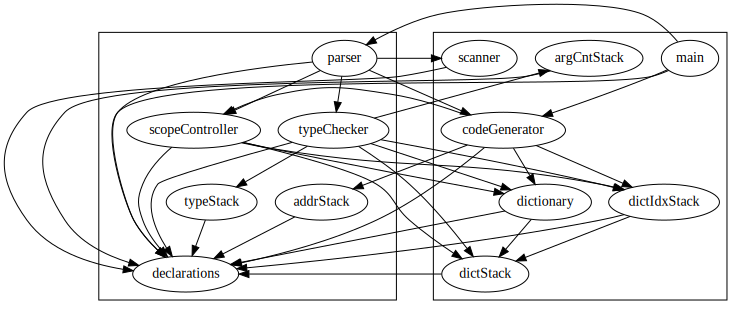

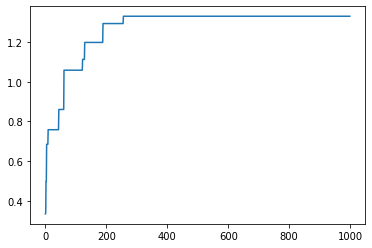

In [59]:
fitness_values = []
selection = tournament_selection
tournament_size = 2
crossover = uniform_crossover
population_size = 20

solution = ga()
plt.plot(fitness_values)
plot_clusters(solution)

Let's have a more systematic look how local search compares to evolutionary search on this problem:

In [60]:
from IPython.utils import io

def run_times(algorithm, repetitions):
    global fitness_values
    result = []
    for i in range(repetitions):
        fitness_values = []
        with io.capture_output() as captured: 
            algorithm()
        result.append(fitness_values[-1])
    return result

[Text(1, 0, 'GA'), Text(2, 0, 'HC')]

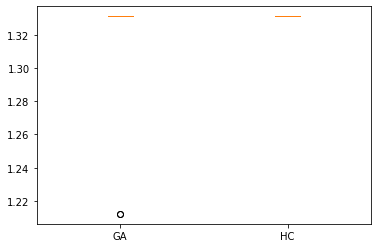

In [61]:
max_steps  = 1000

selection       = tournament_selection
tournament_size = 2
crossover       = singlepoint_crossover
elite_size      = 1
population_size = 20

results = {"GA" : run_times(ga, 10), 
           "HC" : run_times(hillclimbing, 10)}
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())

There probably isn't much difference (if anything, the GA may perform worse). We can, however, look at more complex problems:

In [62]:
module_ids = {}
name_to_id = {}
connections = []

parse_mdg("data/mdg/telnet2.mdg")

This is the classic Unix network application `telnet`, which is slightly larger than the compiler example:

In [63]:
print(f"{len(module_ids)} modules, {len(connections)} connections")

28 modules, 81 connections


It's still not really large, but anything beyond that would require a somewhat more efficient implementation to calculate the fitness values, and in particular to cache them to avoid redundant fitness calculations. Be warned, running the next steps might take some time, and so we'll just do a single run:

Iteration 0, best fitness: 0.5843380500096919
Iteration 1, best fitness: 0.6356100656652691
Iteration 3, best fitness: 0.6914736051108981
Iteration 5, best fitness: 0.7024036842220073
Iteration 6, best fitness: 0.7128948744978186
Iteration 6, best fitness: 0.7167328275895031
Iteration 6, best fitness: 0.7213243513795548
Iteration 6, best fitness: 0.7622795115332429
Iteration 8, best fitness: 0.7946308600312726
Iteration 10, best fitness: 0.8952875127222741
Iteration 13, best fitness: 0.9271999723850062
Iteration 15, best fitness: 0.9316171614011355
Iteration 15, best fitness: 0.983063511830635
Iteration 18, best fitness: 0.9980058788073509
Iteration 19, best fitness: 1.021956958590248
Iteration 21, best fitness: 1.0688117852296959
Iteration 22, best fitness: 1.0992417674227974
Iteration 24, best fitness: 1.0992417674227977
Iteration 25, best fitness: 1.1051414339085572
Iteration 29, best fitness: 1.124675324675325
Iteration 39, best fitness: 1.1297057373006743
Iteration 46, best fitnes

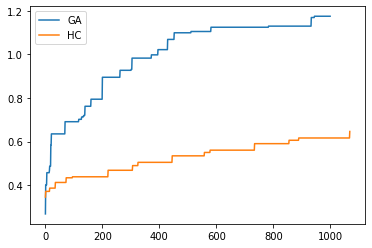

In [64]:
fitness_values = []
selection = tournament_selection
tournament_size = 2
population_size = 20
max_steps = 1000
solution = ga()

ga_values = fitness_values

fitness_values = []
hillclimbing()

plt.plot(ga_values, label="GA")
plt.plot(fitness_values, label="HC")
plt.legend()

Even without multiple runs of the algorithms to make a sound comparison, we usually see a clear trend that the GA by far outperforms the hillclimber on this problem. The reason is that the search space with this problem has become so large that the hillclimber spends far too much time exploring the vincinity of the starting point so that it misses much of the search space (at least given the tight constraint of 1000 fitness evaluations).